In [1]:
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from osgeo import gdal

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from osgeo import gdal

with rasterio.open(r'F:\wenqu\Aviris\classification\masked_aviris_trait\site7_sla_ymax.tif') as src:
    img = src.read()
# Convert image to 32-bit floating point
img = np.transpose(img, (1, 2, 0))
img_rgb = img.astype(np.uint8)

In [3]:
img.shape

(6396, 693, 1)

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from osgeo import gdal





# Open the image with GDAL
dataset = gdal.Open(r'F:\wenqu\Aviris\classification\masked_aviris_trait\site7_sla_ymax.tif')
# Assuming the background/nodata value is known (e.g., 0 or another specific value)
# Read the first band
band = dataset.GetRasterBand(1)
img = band.ReadAsArray()

# Get nodata value
nodata_value = band.GetNoDataValue()
if nodata_value is not None:
    mask = img != nodata_value
else:
    mask = np.ones_like(img, dtype=bool)  # Assume all data is valid if no nodata value is set

# Masked array to ignore nodata values
masked_img = np.ma.masked_array(img, ~mask)

# Normalize the valid data
min_val = masked_img.min()
max_val = masked_img.max()

# Avoid division by zero if the image is flat
if max_val != min_val:
    normalized_img = (masked_img - min_val) * 255 / (max_val - min_val)
else:
    normalized_img = np.ma.masked_array(np.zeros_like(masked_img), mask=~mask)

# Fill nodata areas in the normalized image
gray = normalized_img.astype(np.uint8)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)



#  .filled(0)






# # # Read and mask each band
# # bands = []
# # for i in range(1, dataset.RasterCount + 1):
# #     band = dataset.GetRasterBand(i).ReadAsArray()
# #     if nodata_value is not None:
# #         band = np.where(band == nodata_value, np.nan, band)  # Replace nodata with NaN
# #     bands.append(band)

# # # Normalize and convert to grayscale, ensuring to ignore NaN values in calculations
# # gray = [np.clip((b - np.nanmin(b)) / (np.nanmax(b) - np.nanmin(b)) * 255, 0, 255) for b in bands]
# # gray = 0.299 * bands[0] + 0.587 * bands[1] + 0.114 * bands[2]
# # gray = np.nan_to_num(gray)  # Convert NaNs to 0 (or another value) if needed

# # # Convert to uint8 for image processing
# # gray = gray.astype('uint8')




In [7]:
adaptive_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)


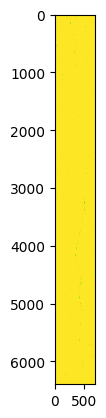

In [14]:
# 使用OpenCV的dilate函数对二值化图像进行膨胀操作
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(adaptive_thresh, kernel, iterations=3)
plt.imshow(sure_bg)

In [17]:
sure_fg

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ...,   0.,   0.,   0.],
       [255., 255., 255., ...,   0.,   0.,   0.],
       [255., 255., 255., ...,   0.,   0.,   0.]], dtype=float32)

In [24]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'F:\wenqu\segmentation\sure_fg3.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(sure_fg, 1)

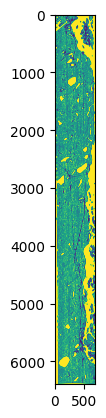

In [23]:
# 计算距离变换
dist_transform = cv2.distanceTransform(adaptive_thresh, cv2.DIST_L2, 5)
# 应用阈值获取确定的前景区域
ret, sure_fg = cv2.threshold(dist_transform, 0.01*dist_transform.max(), 255, cv2.THRESH_BINARY)
plt.imshow(sure_fg)

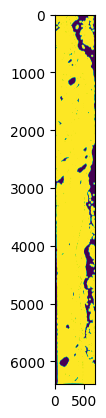

In [18]:
# 确定的前景区域需要转换成整形，去掉阈值化的效果，以便后续处理
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown)

In [21]:
img_rgb.shape

(6396, 693, 1)

In [20]:
# Label markers
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply Watershed
cv2.watershed(img_rgb, np.int32(markers))

# Generate boundaries
image[markers == -1] = [0, 255, 0]

cv2.imshow('Detected Objects', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'cv::watershed'


In [ ]:
# # Find contours
# #used for shape analysis and object detection and recognition
# contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# # Draw contours on the original image
# image_with_contours = cv2.drawContours(img_rgb.copy(), contours, -1, (0,255,0), 3)

# # Show the image with contours
# cv2.imshow('Contours', image_with_contours)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [18]:


# Create an empty image to store markers
markers = np.zeros_like(blurred, dtype=int)

# Fill contours to create markers
for i, contour in enumerate(contours):
    cv2.drawContours(markers, contours, i, (i+1), -1)

# Background marker
markers[adaptive_thresh == 0] = 0


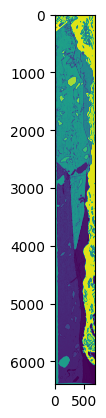

In [19]:
plt.imshow(markers)

In [23]:
# Ensure img_rgb is a 2D array first, by removing the singleton dimension if necessary
if img_rgb.shape[2] == 1:
    img_rgb = img_rgb.squeeze()

# Convert the 2D grayscale image to a 3-channel BGR image
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2BGR)


In [24]:
img_bgr.shape


(6396, 693, 3)

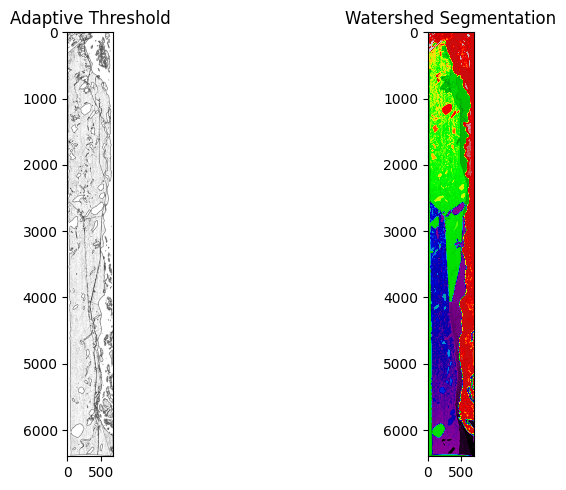

In [25]:
watershed_result = cv2.watershed(img_bgr, markers.astype(np.int32))

# Visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(adaptive_thresh, cmap='gray')
plt.title('Adaptive Threshold')

plt.subplot(1, 2, 2)
plt.imshow(watershed_result, cmap='nipy_spectral')
plt.title('Watershed Segmentation')

plt.tight_layout()
plt.show()


In [27]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'F:\wenqu\segmentation\watershed_result_veg.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(watershed_result, 1)

In [ ]:
import os
import numpy as np
import tifffile as tiff

# Define your folder path here
folder_path = r'F:\wenqu\segmentation\output'
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

unique_labels = np.unique(watershed_result)

for label in unique_labels:
    if label == 0:  # Assuming 0 is the background or not interested
        continue

    # Create a mask for the current segment
    mask = watershed_result == label

    # Apply the mask to the original image to extract the segment
    segment = np.zeros_like(img, dtype=np.uint8)
    segment[mask] = img[mask]

    # Construct the full path where the segment will be saved
    segment_filename = f'segment_{label}.tif'
    segment_full_path = os.path.join(folder_path, segment_filename)

    # Save the segment as a TIFF file at the specified location
    tiff.imwrite(segment_full_path, segment)


In [8]:
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
print(ret)



# # noise removal
# # it is a dialation followed by erosion
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

# # sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)

# Threshold
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
unique_markers = np.unique(markers)
# Add one to all markers so that sure background is not 0, but 1
markers = markers + 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply the Watershed algorithm
markers = cv2.watershed(img_rgb, markers)
img[markers == -1] = [255, 0, 0]  # Mark boundaries in red

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(markers, cmap='jet')
plt.title('Watershed Markers')
plt.axis('off')

plt.tight_layout()
plt.show()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [9]:
img.dtype

dtype('float32')

In [11]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'F:\wenqu\segmentation\img.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(img[:,:,1], 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


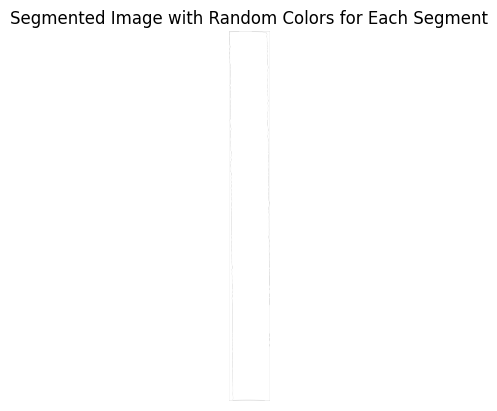

In [10]:
# Assuming `markers` are correctly calculated from the watershed algorithm
unique_markers = np.unique(markers)
segmented_img = np.zeros_like(img)

for marker in unique_markers:
    # Skip background or border markers if necessary
    if marker in [0, -1]:  # Assuming 0 is background and -1 is borders
        continue
    
    # Create a mask for the current segment
    mask = markers == marker
    # Apply a color or process each segment as needed
    # For demonstration, let's fill each segment with a random color
    segmented_img[mask] = np.random.randint(0, 255, size=3)

# Display the processed image
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image with Random Colors for Each Segment')
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


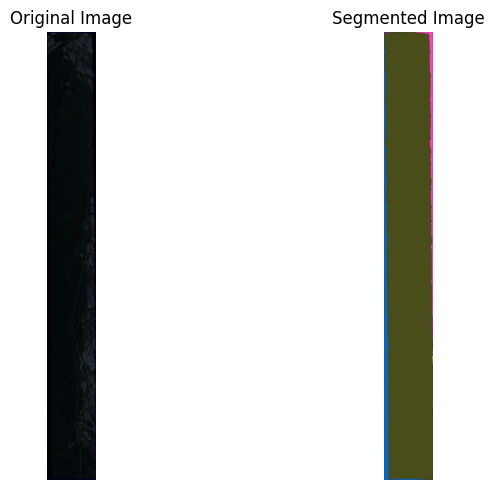

In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Assuming 'img' is your original image and 'markers' is the output from the Watershed algorithm
# Let's first define a function to generate distinct colors
def generate_distinct_colors(n):
    np.random.seed(0)  # For reproducibility
    return [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(n)]

# Generate colors for each segment
num_segments = len(np.unique(markers)) - 2  # Exclude background and boundary markers
colors = generate_distinct_colors(num_segments)

# Create a blank image for the segmentation visualization
segmented_image = np.zeros(img.shape, np.uint8)

# Map each segment to a color
for i, marker in enumerate(np.unique(markers)):
    if marker == 0 or marker == -1:  # Assuming 0 is the background and -1 are the borders
        continue  # Skip these markers
    segmented_image[markers == marker] = colors[i - 2]  # Adjust index for skipped markers

# Visualization
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Segmented Image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
segmented_image.shape

(6396, 697, 3)

In [36]:
import numpy as np
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape, Polygon
from shapely.affinity import affine_transform
from shapely.ops import unary_union

# Path to the original raster image
raster_path = r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif'
# Output path for the shapefile
shapefile_path = 'F:/wenqu/segmentation/segmented_zones.shp'

# Function to convert segmentation markers to GeoDataFrame
def markers_to_geodataframe(markers, src):
    # Extract shapes and corresponding values from markers using rasterio's shapes function
    mask = markers != 0  # Assuming '0' is the background value
    shape_generator = shapes(markers.astype(np.int16), mask=mask, transform=src.transform)

    polygons = []
    values = []
    for geom, value in shape_generator:
        if value > 0:  # Assuming positive values represent segments of interest
            polygons.append(shape(geom))
            values.append(value)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame({'segment_label': values, 'geometry': polygons})
    gdf.crs = src.crs  # Set CRS to match the source raster
    
    return gdf

# Validate and possibly fix geometries
def validate_and_fix_geometry(geom):
    if geom.is_valid:
        return geom
    else:
        # Attempt a "buffer(0)" fix, which can resolve some invalid geometries
        fixed_geom = geom.buffer(0)
        if fixed_geom.is_valid:
            return fixed_geom
    return None

# Load raster
with rasterio.open(raster_path) as src:
    original_crs = src.crs
    markers = src.read(1)  # Example: read the first band as markers, adjust according to your data

# Convert markers to GeoDataFrame
gdf = markers_to_geodataframe(markers, src)

# Validate and fix geometries
gdf['geometry'] = gdf['geometry'].apply(validate_and_fix_geometry)

# Remove any None geometries after attempted fix
gdf = gdf.dropna(subset=['geometry'])

# Write to Shapefile
gdf.to_file(shapefile_path)


C:\Users\15086\AppData\Local\Temp\ipykernel_14872\1698577287.py:59: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(shapefile_path)


In [27]:
from osgeo import gdal, ogr, osr
import numpy as np
import cv2
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import os
def raster_to_shapefile(markers, output_shapefile):
    # Create a new shapefile
    driver = ogr.GetDriverByName('ESRI Shapefile')
    ds = driver.CreateDataSource(output_shapefile)
    layer = ds.CreateLayer('', None, ogr.wkbPolygon)
    layer.CreateField(ogr.FieldDefn('ID', ogr.OFTInteger))
    
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # Assuming a WGS84 projection; adjust as necessary
    layer.SetSpatialRef(srs)
    
    # Iterate through unique markers, skipping the background and boundary markers
    for segment_id in np.unique(markers):
        if segment_id in [0, -1]:  # Skipping background (0) and boundaries (-1)
            continue
        
        # Create a mask for the current segment
        mask = markers == segment_id
        # Find contours for the mask
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            # Convert contour points to a format suitable for Shapely
            contour_points = [tuple(point[0]) for point in contour]
            polygon = Polygon(contour_points)
            if not polygon.is_valid:
                continue  # Skip invalid polygons
            
            # Create a new feature (polygon) in the shapefile
            feature = ogr.Feature(layer.GetLayerDefn())
            feature.SetField('ID', int(segment_id))
            geom = ogr.CreateGeometryFromWkb(polygon.wkb)
            feature.SetGeometry(geom)
            layer.CreateFeature(feature)
            feature = None  # Destroy the feature to commit it to the layer
    
    # Close and save the shapefile
    ds = None

# Assuming 'markers' is your segmentation result and 'segmented_zones.shp' is your desired output file
raster_to_shapefile(markers, r'F:\wenqu\segmentation\segmented_zones.shp')


AttributeError: 'NoneType' object has no attribute 'CreateLayer'

In [26]:
markers

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0]], dtype=int32)

In [6]:
img[:,:,1].shape

(6396, 697)

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from osgeo import gdal

with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    img = src.read()
# Convert image to 32-bit floating point
img = np.transpose(img, (1, 2, 0))
img_rgb = img.astype(np.uint8)
# Open the image with GDAL
dataset = gdal.Open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif')
# Assuming the background/nodata value is known (e.g., 0 or another specific value)
nodata_value = dataset.GetRasterBand(1).GetNoDataValue()  # Adjust this if the nodata value is different

# Read and mask each band
bands = []
for i in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(i).ReadAsArray()
    if nodata_value is not None:
        band = np.where(band == nodata_value, np.nan, band)  # Replace nodata with NaN
    bands.append(band)

# Normalize and convert to grayscale, ensuring to ignore NaN values in calculations
bands = [np.clip((b - np.nanmin(b)) / (np.nanmax(b) - np.nanmin(b)) * 255, 0, 255) for b in bands]
gray = 0.299 * bands[0] + 0.587 * bands[1] + 0.114 * bands[2]
gray = np.nan_to_num(gray)  # Convert NaNs to 0 (or another value) if needed
# Apply a binary threshold to get a binary image
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal (optional, improves the marker detection)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply the watershed
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

# Displaying the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.show()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1555: error: (-2:Unspecified error) in function 'double __cdecl cv::threshold(const class cv::_InputArray &,const class cv::_OutputArray &,double,double,int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 5 (CV_32FC1)


In [2]:
# Open the TIFF file
dataset = gdal.Open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif', gdal.GA_ReadOnly)

In [3]:
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    img = src.read()
# Convert image to 32-bit floating point
img = np.transpose(img, (1, 2, 0))
img_rgb = img.astype(np.uint8)
# img_rgb_32f = img.astype(np.float32)
# img_rgb_8bit = np.clip(img_rgb_32f * 255.0, 0, 255).astype('uint8')

In [4]:
# Assuming the background/nodata value is known (e.g., 0 or another specific value)
nodata_value = dataset.GetRasterBand(1).GetNoDataValue()  # Adjust this if the nodata value is different

# Read and mask each band
bands = []
for i in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(i).ReadAsArray()
    if nodata_value is not None:
        band = np.where(band == nodata_value, np.nan, band)  # Replace nodata with NaN
    bands.append(band)

# Normalize and convert to grayscale, ensuring to ignore NaN values in calculations
bands = [np.clip((b - np.nanmin(b)) / (np.nanmax(b) - np.nanmin(b)) * 255, 0, 255) for b in bands]
gray = 0.299 * bands[0] + 0.587 * bands[1] + 0.114 * bands[2]
gray = np.nan_to_num(gray)  # Convert NaNs to 0 (or another value) if needed

# Convert to uint8 for image processing
gray_image = gray.astype('uint8')

In [5]:
# Apply adaptive threshold to find markers for the watershed algorithm
adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                        cv2.THRESH_BINARY_INV, 11, 2)

In [6]:
adaptive_thresh.shape

(6396, 697)

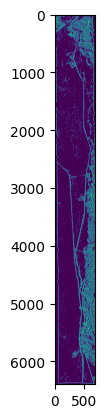

In [7]:
plt.imshow(adaptive_thresh)

In [8]:

# Noise removal (optional, can help in some cases)
kernel = np.ones((3,3), np.uint8)
# this is another type of erosion to move noise
opening = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# dialtion to increase the object area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

In [9]:
sure_bg.shape

(6396, 697)

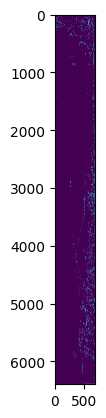

In [10]:
plt.imshow(opening)

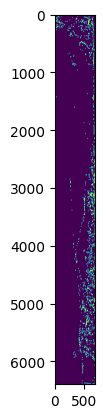

In [11]:
plt.imshow(sure_bg)

In [12]:
# Finding sure foreground area
# value of each pixel is replaced by its distance to the nearest background pixel
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

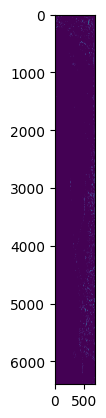

In [13]:
plt.imshow(dist_transform)

In [14]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.8*dist_transform.max(), 255, 0)
# same threshold was applied to each pixel, if the pixel value smaller than threshold will be set to 0, otherwise set to maximum value
# source image, threshold value, maximum value, type of thresholding
# sure_fg = cv2.adaptiveThreshold(dist_transform.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                                 cv2.THRESH_BINARY, 11, 2)
# two returns: the threshold used in the function, thersholded image
# 0.1*dist_transform.max(): any pixel value that is less than 10% of the maximum value in the distance will be considered background

In [15]:
sure_fg.shape

(6396, 697)

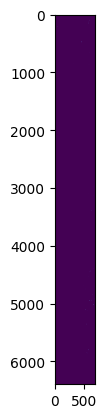

In [16]:
plt.imshow(sure_fg)

In [17]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

In [18]:
# Marker labelling
# number of labels; labeled image
ret, markers = cv2.connectedComponents(sure_fg)

In [19]:
markers.shape

(6396, 697)

In [20]:
ret

80

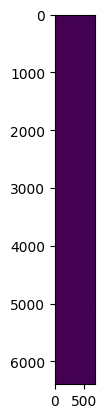

In [21]:
plt.imshow(markers)

In [22]:
markers.dtype

dtype('int32')

In [23]:
# markers = markers+1
# markers[unknown==255] = 0

In [24]:
img_rgb.shape

(6396, 697, 3)

In [25]:
markers = cv2.watershed(img_rgb,markers)
# img[markers == -1] = [255,0,0]

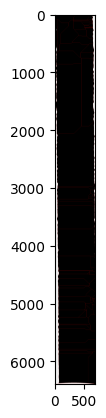

In [26]:
img_rgb[markers == -1] = [255, 0, 0]  # Mark boundaries with red on the 8-bit image

# Display the result
plt.imshow(img_rgb)
plt.show()

In [28]:
img_rgb.shape

(6396, 697, 3)

In [27]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'F:\wenqu\segmentation\img_rgb.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(img_rgb, 1)

ValueError: Source shape (1, 6396, 697, 3) is inconsistent with given indexes 1

In [28]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'F:\wenqu\segmentation\dist_transform.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(dist_transform, 1)

In [37]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Ensure markers are correctly prepared as a 32-bit signed single-channel image
markers_int32 = markers.astype(np.int32)

# Now apply the watershed algorithm
cv2.watershed(img_rgb_8bit, markers_int32)

# The watershed algorithm modifies the markers array in-place, marking -1 at boundaries
# Optionally, visualize the result on the original or the 8-bit image
img_rgb_8bit[markers_int32 == -1] = [255, 0, 0]  # Mark boundaries with red on the 8-bit image

# Display the result
plt.imshow(img_rgb_8bit)
plt.show()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'cv::watershed'


In [8]:
import rasterio

# Load the original image with rasterio to get metadata
with rasterio.open(r'F:\wenqu\Aviris\aviris_rgb_tif\site7.tif') as src:
    profile = src.profile

# Update the metadata for the grayscale image
profile.update(dtype=rasterio.uint8, count=1,  nodata=None)

# Save the grayscale image with the same reference system
output_path = r'F:\wenqu\segmentation\gray.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(gray, 1)